In [98]:
import pandas as pd
from pycaret.classification import *
from sklearn.model_selection import train_test_split
from typing import Any
from funcoes import aplicar_imputacao_treino,pipeline_modelagem,plot_comparacao_roc \
                    ,plot_comparacao_prc,aplicar_imputacao_teste,escolher_estrategia_imputacao \
                    ,plot_comparacao_ks,plot_comparacao_decil,gerar_tabela_avaliacao,plotar_ks_safra \
                    ,calcular_ks_por_safra,monitorar_variaveis_continuas,obter_importancia_variaveis,calcular_metricas_multiplas


In [99]:
#Lendo a base de treino
train_selecionada = pd.read_csv("train_selecionada.csv")

In [100]:
#lendo a base de teste oos
test_oos = pd.read_csv("test_oos.csv")
test_oos = test_oos[train_selecionada.columns]

In [101]:
#verificando o schema
train_selecionada.shape,test_oos.shape

((7315, 43), (1829, 43))

In [102]:
# Por padrão o Pycaret não permite a imputação dinâmica de missings, então vamos tratar os missings com nossa função e depois aplicar no teste OOS do pycaret
# Assim o setup não vai precisar tratar os missings, pois o dataset não terá missings para tratar
# Vamos salvar esse pipeline e utilizar no código de escoragem

In [103]:
regra_imputacao = escolher_estrategia_imputacao(train_selecionada)
train_selecionada, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train_selecionada,regra_imputacao)
test_oos = aplicar_imputacao_teste(test_oos,regra_imputacao, dict_mediana, dict_media)

In [104]:
train_selecionada.shape, test_oos.shape

((7315, 43), (1829, 43))

In [105]:
#7 min pra treinar com polinomial features
#
train_selecionada, test_oos, tuned_lightgbm, tuned_lr,train_lightgbm_escorado, \
test_lightgbm_escorado,train_regressao_escorado, test_regressao_escorado = pipeline_modelagem(train_selecionada, test_oos, id_col='id', safra_col='safra', target_col='y',lista_vars_numericas_categorizar=[])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7759,0.7812,0.4072,0.6699,0.5051,0.3718,0.3916,0.0930
lr,Logistic Regression,0.7758,0.7801,0.3717,0.6907,0.4828,0.3561,0.3841,0.0110


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7618,0.7456,0.3548,0.6408,0.4567,0.3199,0.3429
1,0.7845,0.8073,0.4839,0.6618,0.5590,0.4209,0.4300
2,0.7876,0.7938,0.3925,0.7300,0.5105,0.3901,0.4208
3,0.7538,0.7527,0.3784,0.5983,0.4636,0.3142,0.3281
4,0.7964,0.8131,0.4677,0.7131,0.5649,0.4394,0.4560
5,0.7675,0.7692,0.3602,0.6634,0.4669,0.3345,0.3600
6,0.7827,0.8014,0.4462,0.6748,0.5372,0.4028,0.4175
7,0.7629,0.7619,0.3602,0.6442,0.4621,0.3253,0.3479
8,0.7918,0.8088,0.4677,0.6960,0.5595,0.4300,0.4445


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7026,0.7629,0.6237,0.4793,0.5421,0.3274,0.3336
1,0.7344,0.8069,0.6667,0.5232,0.5863,0.3949,0.4012
2,0.7360,0.7996,0.6774,0.5250,0.5915,0.4011,0.4082
3,0.7006,0.7498,0.6757,0.4771,0.5593,0.3426,0.3545
4,0.7371,0.8243,0.7258,0.5253,0.6095,0.4189,0.4313
5,0.6915,0.7640,0.5914,0.4641,0.5201,0.2976,0.3024
6,0.7219,0.8021,0.6989,0.5058,0.5869,0.3853,0.3967
7,0.7340,0.7740,0.6344,0.5244,0.5742,0.3834,0.3870
8,0.7508,0.8271,0.7634,0.5420,0.6339,0.4531,0.4684


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7724,0.7704,0.3441,0.6957,0.4604,0.3365,0.3700
1,0.7936,0.8063,0.4194,0.7358,0.5342,0.4142,0.4412
2,0.7800,0.7982,0.3710,0.7113,0.4876,0.3647,0.3961
3,0.7553,0.7372,0.3405,0.6176,0.4390,0.2989,0.3206
4,0.7948,0.8115,0.4194,0.7429,0.5361,0.4172,0.4453
5,0.7553,0.7608,0.2957,0.6471,0.4059,0.2778,0.3117
6,0.7796,0.7992,0.4032,0.6881,0.5085,0.3787,0.4012
7,0.7660,0.7568,0.3656,0.6538,0.4690,0.3339,0.3571
8,0.7964,0.8093,0.4140,0.7549,0.5347,0.4182,0.4492


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7739,0.7701,0.3441,0.7033,0.4621,0.3396,0.3744
1,0.7936,0.8058,0.4194,0.7358,0.5342,0.4142,0.4412
2,0.7785,0.7982,0.3656,0.7083,0.4823,0.3591,0.3909
3,0.7599,0.7372,0.3405,0.6364,0.4437,0.3080,0.3325
4,0.7948,0.8117,0.4194,0.7429,0.5361,0.4172,0.4453
5,0.7568,0.7609,0.2957,0.6548,0.4074,0.2809,0.3161
6,0.7796,0.7991,0.4032,0.6881,0.5085,0.3787,0.4012
7,0.7690,0.7582,0.3710,0.6635,0.4759,0.3426,0.3664
8,0.7948,0.8096,0.4086,0.7525,0.5296,0.4128,0.4443


Fitting 10 folds for each of 10 candidates, totalling 100 fits


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
0,Light Gradient Boosting Machine,0.7213,0.7875,0.6697,0.5048,0.5753,0.3740,0.3826,0.0590
1,Logistic Regression,0.7764,0.7803,0.3706,0.6942,0.4827,0.3568,0.3855,0.0120



🏆 **Modelo Vencedor:** LGBMClassifier(boosting_type='gbdt', class_weight='balanced',
               colsample_bytree=0.75, importance_type='split',
               learning_rate=0.03, max_depth=3, min_child_samples=20,
               min_child_weight=0.001, min_split_gain=0.0, n_estimators=200,
               n_jobs=-1, num_leaves=10, objective=None, random_state=42,
               reg_alpha=1, reg_lambda=0.1, subsample=0.75,
               subsample_for_bin=200000, subsample_freq=0)
✅ Regressão Logística escolhida com AUC: 0.7803


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7461,0.8228,0.7149,0.5381,0.6140,0.4304,0.4401


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.7332,0.7917,0.6919,0.5204,0.5940,0.4012,0.4102


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7776,0.7841,0.3717,0.7001,0.4856,0.3603,0.3897


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7813,0.7856,0.3740,0.7148,0.4911,0.3687,0.4001


base escorada pycaret
         id   safra      VAR_15        VAR_9       VAR_54  VAR_3       VAR_5  \
0      7913  201405   80.410004   700.000000   700.000000    0.0   73.959999   
1      7343  201401   65.980003  1000.000000  1230.000000    1.0   68.980003   
2      9046  201407   49.980000  2209.000000  2209.000000    0.0   68.980003   
3      5227  201405   53.110001  1000.000000  1550.000000    0.0   70.470001   
4     10491  201404  157.649994  1479.390015  1479.390015    0.0   68.980003   
...     ...     ...         ...          ...          ...    ...         ...   
7310  10447  201402   52.380001   500.000000  1230.000000    0.0   67.629997   
7311   2189  201402   49.980000  1000.000000  1000.000000    0.0   18.410000   
7312   6839  201409   52.430000  1000.000000  2000.000000    0.0  127.599998   
7313   1422  201409   59.980000   900.000000   900.000000    1.0   68.980003   
7314   5592  201408   26.389999  1000.000000  2200.000000    0.0   16.260000   

      VAR_1  VAR_

In [106]:
#Ler a base OOT
test_oot = pd.read_csv('teste_oot.csv')
test_oot = test_oot[train_selecionada.columns]

In [107]:
test_oot.shape

(1594, 43)

In [108]:
#### Escoragem dos Modelos no dataset de OOT ####
#Primeiro vamos aplicar a regra de imputação de missings
train_selecionada, regra_imputacao, dict_mediana, dict_media = aplicar_imputacao_treino(train_selecionada,regra_imputacao)
test_oot = aplicar_imputacao_teste(test_oot,regra_imputacao, dict_mediana, dict_media)


In [109]:
#Agora basta escorar a base oot nos dois modelos

# 🔹 ESCORAGEM DOS MODELOS

# Aplicando LightGBM no conjunto de treino e teste
test_oot_lightgbm = predict_model(tuned_lightgbm, data=test_oot, probability_threshold=0.5, raw_score=True)
test_oot_lightgbm = test_oot_lightgbm[['id','safra','y','prediction_score_0','prediction_score_1']].rename(columns={'prediction_score_0':'score_0','prediction_score_1':'score_1'})


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.6932,0.7121,0.5092,0.5571,0.5321,0.3046,0.3052


In [110]:
test_oot_regressao = predict_model(tuned_lr, data=test_oot, probability_threshold=0.5, raw_score=True)
test_oot_regressao = test_oot_regressao[['id','safra','y','prediction_score_0','prediction_score_1']].rename(columns={'prediction_score_0':'score_0','prediction_score_1':'score_1'})

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.6788,0.7062,0.1190,0.6771,0.2025,0.1115,0.1785


In [111]:
train_lightgbm_escorado.head()

,id,safra,y,score_1,score_0
0,7913,201405,0,0.2160,0.7840
1,7343,201401,1,0.9434,0.0566
2,9046,201407,1,0.7688,0.2312
3,5227,201405,0,0.3838,0.6162
4,10491,201404,1,0.6368,0.3632


In [112]:
test_oot_regressao.head()

,id,safra,y,score_0,score_1
0,4,201412,0,0.7465,0.2535
1,13,201411,1,0.7593,0.2407
2,15,201412,0,0.6977,0.3023
3,17,201412,0,0.2683,0.7317
4,20,201411,0,0.8292,0.1708


In [113]:
#métricas que dependem do Limiar de corte
#Acurácia: Percentual de acertos (total correto / total de previsões).
#Precisão: Entre os positivos previstos, quantos realmente são positivos (TP / (TP + FP)).
#Recall: Entre os positivos reais, quantos foram identificados corretamente (TP / (TP + FN)).
#F1-score: Média harmônica entre precisão e recall (2 × (Precisão × Recall) / (Precisão + Recall)).
#AUC (Área sob a curva ROC): Mede a capacidade do modelo de separar classes, variando entre 0 e 1.
#KS MAX (Kolmogorov-Smirnov): Diferença máxima entre taxas cumulativas de verdadeiros positivos e falsos positivos.
#GINI: Mede a desigualdade na distribuição das previsões, baseado no AUC (GINI = 2 × AUC - 1).
#TP (True Positive): Positivos corretos (modelo previu positivo e era positivo).
#FP (False Positive): Falsos positivos (modelo previu positivo, mas era negativo).
#TN (True Negative): Negativos corretos (modelo previu negativo e era negativo).
#FN (False Negative): Falsos negativos (modelo previu negativo, mas era positivo).

bases_nomeadas = {
    "Train - LightGBM": train_lightgbm_escorado,
    "Test - LightGBM": test_lightgbm_escorado,
    "OOT - LightGBM": test_oot_lightgbm,
    "Train - Regressão Logística": train_regressao_escorado,
    "Test - Regressão Logística": test_regressao_escorado,
    "OOT - Regressão Logística": test_oot_regressao
}
calcular_metricas_multiplas(bases_nomeadas, limiar = 0.3) #0.3 significa que acima de 30% de prob de mau consideramos mau.

,Nome da Base,Acurácia,Precisão,Recall,F1-score,AUC,KS MAX,GINI,TP,FP,TN,FN
0,Train - LightGBM,0.5465,0.3793,0.9511,0.5423,0.8228,0.4753,0.6456,1965,3216,2033,101
1,Test - LightGBM,0.5156,0.3607,0.9283,0.5195,0.7917,0.4569,0.5834,479,849,464,37
2,OOT - LightGBM,0.5621,0.4305,0.8626,0.5744,0.7121,0.3082,0.4242,471,623,425,75
3,Train - Regressão Logística,0.7303,0.5181,0.6452,0.5747,0.7841,0.4152,0.5682,1333,1240,4009,733
4,Test - Regressão Logística,0.7343,0.5232,0.6550,0.5818,0.7856,0.4297,0.5713,338,308,1005,178
5,OOT - Regressão Logística,0.6907,0.5621,0.4396,0.4933,0.7062,0.3186,0.4123,240,187,861,306


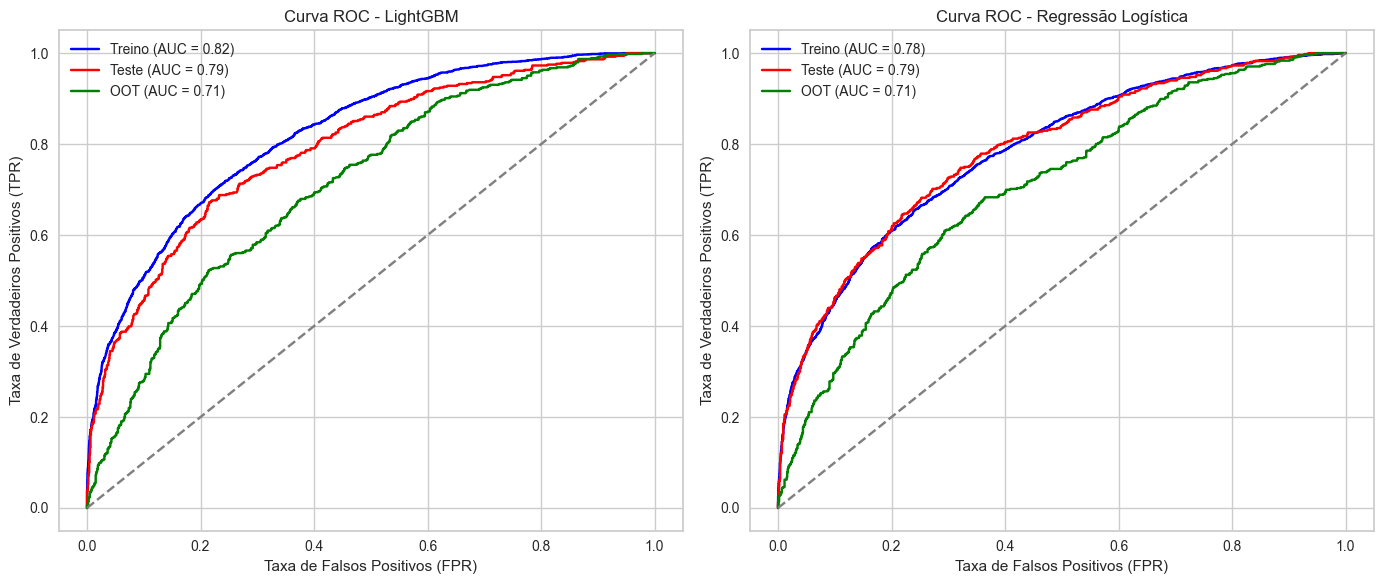

In [114]:
#1. Curva ROC (Receiver Operating Characteristic)
#Mostra a relação entre Taxa de Verdadeiros Positivos (TPR - Sensibilidade) e Taxa de Falsos Positivos (FPR).
#Quanto mais próxima a curva estiver do canto superior esquerdo, melhor o modelo.
#A métrica principal associada é a AUC-ROC (Área sob a Curva ROC), que indica a capacidade do modelo em distinguir classes.
#Usar com objetivo for avaliar o quão bem o modelo separa as classes, independentemente da distribuição dos dados.

#Roc para oot  2M

plot_comparacao_roc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

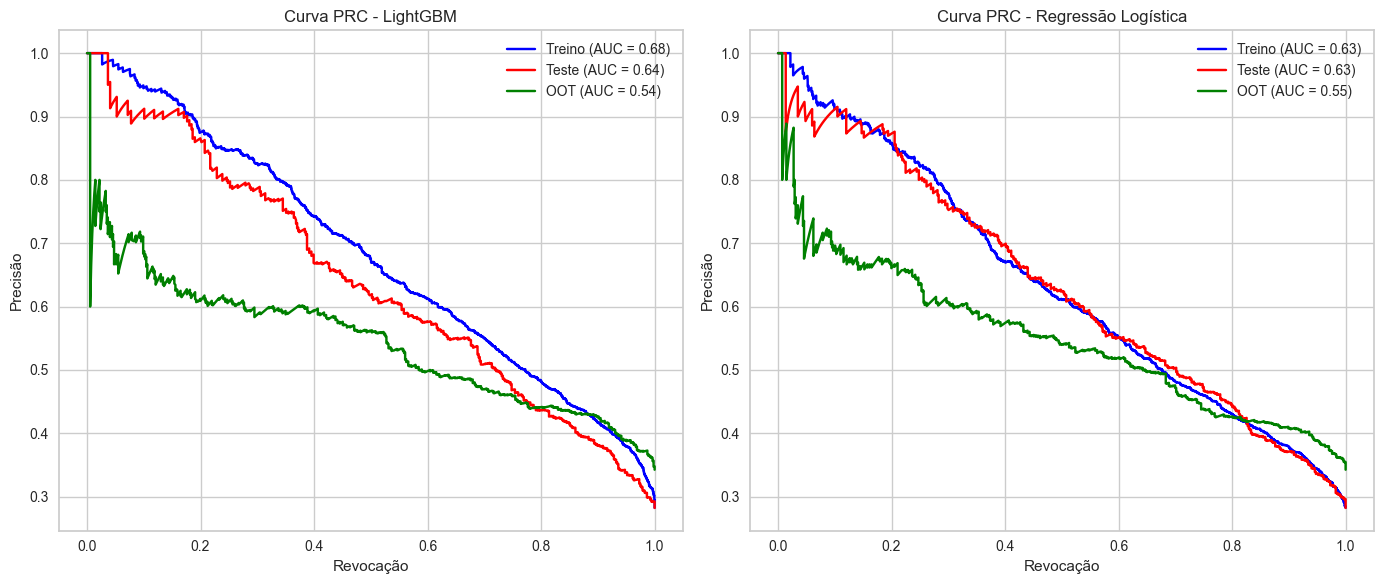

In [116]:
#2. Curva PRC (Precision-Recall Curve)
#Mostra a relação entre Precisão (Precision) e Revocação (Recall - Sensibilidade).
#Útil quando a classe positiva é rara (dados desbalanceados).
#A métrica associada é a AUC-PR, que mede a área sob essa curva.
#Se houver um grande desbalanceamento entre as classes (por exemplo, detecção de fraudes, doenças raras).

plot_comparacao_prc(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

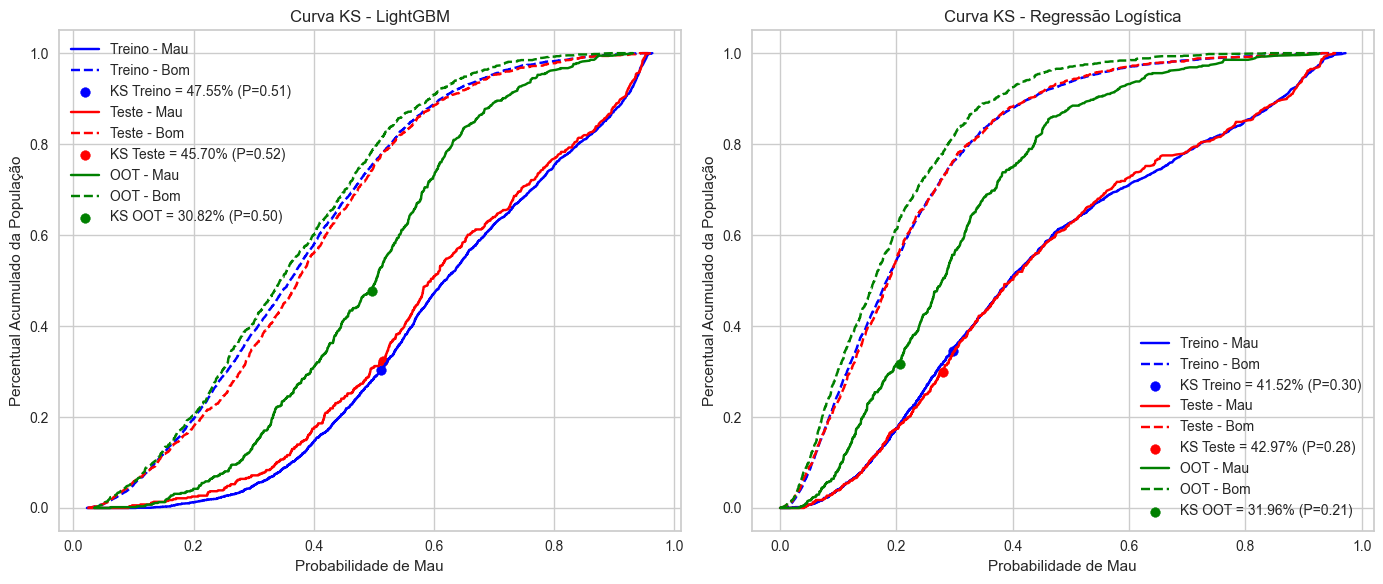

In [117]:
#3. Curva KS (Kolmogorov-Smirnov Curve)
#Mede a diferença máxima entre as distribuições cumulativas de positivos e negativos.
#Quanto maior o valor de KS, melhor a separação do modelo.
#Muito utilizada em modelos de risco de crédito e em cenários onde se quer saber o ponto de máxima separação entre as classes.

plot_comparacao_ks(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao
)

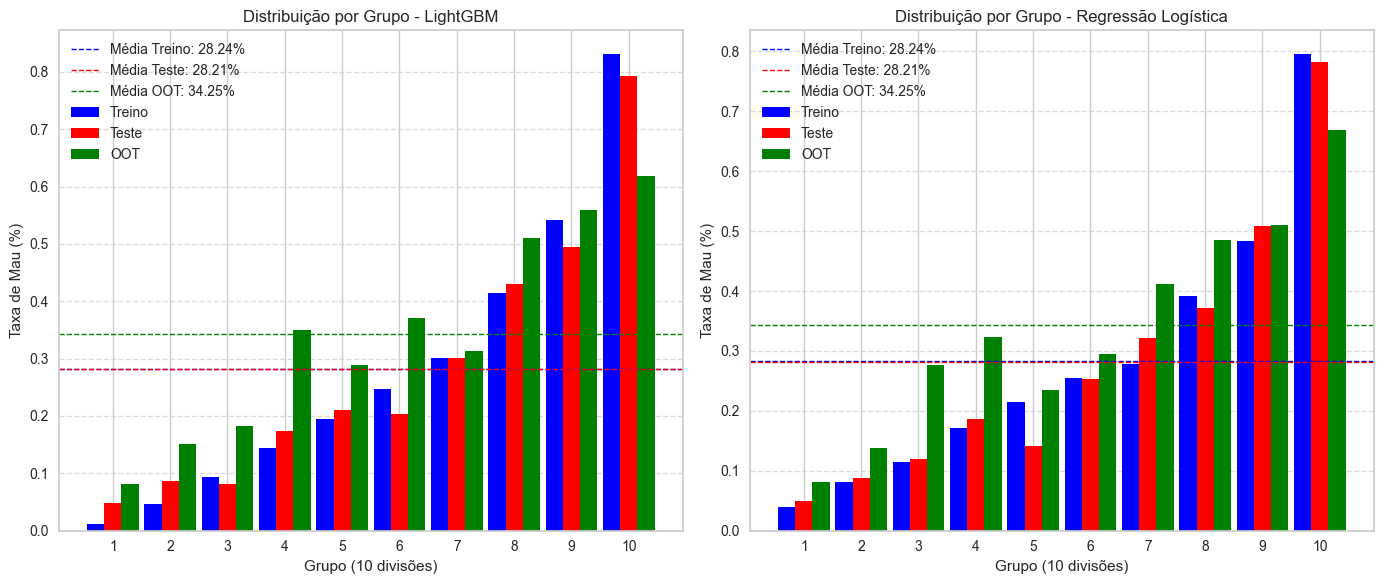

In [118]:
#Verificar se o score está ordenando bem e seguindo uma lógica onde quanto maior a probabilidade de mau, maior o % de maus acumulados
#Ordenamos o score do menor para o maior 
#Criamos faixas discretas e verificamos a quantidade de maus em cada faixa
#Quanto mais ordenadas forem as faixas melhor
plot_comparacao_decil(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao,
    num_divisoes= 10)

In [119]:
tabela = gerar_tabela_avaliacao(
    train_lightgbm_escorado, 
    test_lightgbm_escorado, 
    train_regressao_escorado, 
    test_regressao_escorado,
    test_oot_lightgbm, 
    test_oot_regressao,
    num_divisoes= 10)

In [120]:
tabela['nome_dataframe'].unique().tolist()

['Train LightGBM',
 'Test LightGBM',
 'Train Regressão',
 'Test Regressão',
 'OOT LightGBM',
 'OOT Regressão']

In [121]:
tabela[tabela['nome_dataframe']=="OOT LightGBM"].head(10)

,nome_dataframe,quantil,score_0 min,score_0 max,total_casos,total_mau,total_bom,maus_acumulados,% maus acumulados,KS
40,OOT LightGBM,1,0.8395,0.9655,160,13,147,13,2.380952,11.645765
41,OOT LightGBM,2,0.7673,0.8391,159,24,135,37,6.776557,20.131840
42,OOT LightGBM,3,0.7099,0.7670,159,29,130,66,12.087912,27.225065
43,OOT LightGBM,4,0.6589,0.7098,160,56,104,122,22.344322,26.892319
44,OOT LightGBM,5,0.6013,0.6582,159,46,113,168,30.769231,29.249853
45,OOT LightGBM,6,0.5489,0.6001,159,59,100,227,41.575092,27.985977
46,OOT LightGBM,7,0.4944,0.5488,160,50,110,277,50.732601,29.324651
47,OOT LightGBM,8,0.4333,0.4939,159,81,78,358,65.567766,21.932234
48,OOT LightGBM,9,0.3568,0.4331,159,89,70,447,81.868132,12.311257
49,OOT LightGBM,10,0.0686,0.3564,160,99,61,546,100.000000,0.000000


In [122]:
#ks por safra publico completo lightgbm
tabela_ks = calcular_ks_por_safra(pd.concat([train_lightgbm_escorado,test_lightgbm_escorado,test_oot_lightgbm]))

In [123]:
tabela_ks

,safra,contagem_de_linhas,ks_max,ponto_ks
0,201401,854,52.196551,0.6092
1,201402,898,50.985425,0.5576
2,201403,873,56.969159,0.5360
3,201404,955,48.820049,0.5149
4,201405,972,48.870112,0.5132
5,201406,902,51.732560,0.4693
6,201407,968,47.942626,0.5109
7,201408,912,43.902338,0.4937
8,201409,877,47.379894,0.4452
9,201410,933,42.651982,0.4282


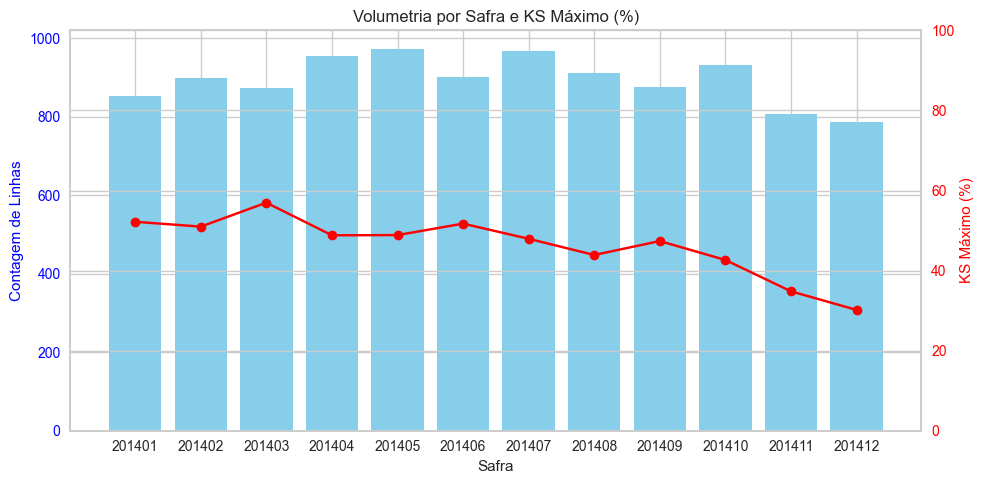

In [124]:
plotar_ks_safra(tabela_ks)

In [125]:
# O que leva nosso modelo a perder performance no OOT?
#Se o modelo perdeu performance no OOT, algumas causas podem ser:
#
#Mudança nos dados – Os padrões dos dados mudaram com o tempo.
#Mudança na relação com a target – As variáveis deixaram de influenciar o resultado da mesma forma.
#Overfitting – O modelo aprendeu muito bem o treino, mas não generaliza para novos períodos.
#Dados desatualizados – O treino foi feito com dados antigos e não reflete a realidade atual.
#Erros no processamento – Alguma transformação nos dados do OOT pode estar errada.
#Fatores externos – Eventos novos afetaram o comportamento dos dados (ex: crise, novas regras).

In [126]:
#Importancia de variáveis non light gbm (quantas vezes a variável foi utilizada para realizar o corte na folha da árvore)
#Os betas (β) na Regressão Logística são os coeficientes que medem o efeito de cada variável independente na probabilidade de um determinado evento ocorrer.

df_lgbm_vars = obter_importancia_variaveis(tuned_lightgbm, "LightGBM")
df_logistica_vars = obter_importancia_variaveis(tuned_lr, "Regressão Logística")

In [127]:
#Se uma variável que é importante para o modelo muda de distribuição, isso pode causar problemas na previsão.

#O p-valor mede a probabilidade de observarmos uma diferença tão grande entre duas amostras apenas por acaso, assumindo que elas vêm da mesma distribuição.
#Se p-valor < 0.05 → Existe menos de 5% de chance de que a diferença seja mero acaso. Ou seja, há evidências estatísticas de que as distribuições são diferentes!
#Se p-valor >= 0.05 → Não há evidências suficientes para afirmar que as distribuições mudaram.
#No caso do KS Test (Kolmogorov-Smirnov), um p-valor < 0.05 indica que a distribuição da variável mudou significativamente entre a safra de referência e a safra atual.

#O PSI (Índice de Estabilidade Populacional) mede a diferença entre duas distribuições.
#Dividimos os dados em faixas de valores, Calculamos as frequências relativas em cada bin para ambas as populações (referência e atual).
#PSI < 0.1 → Pequena diferença (distribuição estável)
#0.1 ≤ PSI < 0.25 → Diferença moderada (monitorar)
#PSI ≥ 0.25 → Diferença significativa (possível problema )


psi,ks = monitorar_variaveis_continuas(pd.concat([train_selecionada,test_oos]), test_oot, [x for x in train_selecionada.columns if x not in ['id','safra','y']])

In [128]:
reprovadas_ks = ks.index.tolist()
reprovadas_psi = psi.index.tolist()

In [129]:
reprovadas = reprovadas_ks + reprovadas_psi

In [130]:
reprovadas

['VAR_15',
 'VAR_9',
 'VAR_54',
 'VAR_3',
 'VAR_5',
 'VAR_1',
 'VAR_28',
 'VAR_60',
 'VAR_58',
 'VAR_17',
 'VAR_30',
 'VAR_2',
 'VAR_59',
 'VAR_53',
 'VAR_20',
 'VAR_57',
 'VAR_44',
 'VAR_52',
 'VAR_76',
 'VAR_4']

In [131]:
avaliar_vars_ks = df_lgbm_vars.merge(ks.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [132]:
avaliar_vars = avaliar_vars_ks.merge(psi.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [133]:
#verificando facilmente como a média da variável VAR_1 mudou nos meses mais recentes do OOT
train_selecionada['VAR_1'].mean(),test_oos['VAR_1'].mean(),test_oot['VAR_1'].mean()

(34.32781954887218, 33.11591033351558, 22.331869510664994)

In [134]:
avaliar_vars

,nome_variavel,importancia,index_x,KS_Stat,p_value,Alerta,index_y
0,VAR_9,169,VAR_9,0.059372,1.328279e-04,Mudança Significativa,NaN
1,VAR_1,154,VAR_1,0.100448,2.242497e-12,Mudança Significativa,NaN
2,VAR_20,121,VAR_20,0.054539,5.952341e-04,Mudança Significativa,NaN
3,VAR_17,108,VAR_17,0.063310,3.561600e-05,Mudança Significativa,NaN
4,VAR_6,103,NaN,NaN,NaN,NaN,NaN
5,VAR_60,73,VAR_60,0.037630,4.158844e-02,Mudança Significativa,NaN
6,VAR_65,61,NaN,NaN,NaN,NaN,NaN
7,VAR_53,61,VAR_53,0.211610,9.479280e-54,Mudança Significativa,NaN
8,VAR_72,58,NaN,NaN,NaN,NaN,NaN
9,VAR_44,56,VAR_44,0.037958,3.886908e-02,Mudança Significativa,NaN


In [135]:
avaliar_vars_ks_lr = df_logistica_vars.merge(ks.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [136]:
avaliar_vars_lr = avaliar_vars_ks_lr.merge(psi.reset_index(drop=False),how='left',left_on='nome_variavel',right_on='index')

In [137]:
avaliar_vars_lr

,nome_variavel,importancia,index_x,KS_Stat,p_value,Alerta,index_y
0,VAR_1,1.009395,VAR_1,0.100448,2.242497e-12,Mudança Significativa,NaN
1,VAR_9,0.430513,VAR_9,0.059372,1.328279e-04,Mudança Significativa,NaN
2,VAR_20,0.421034,VAR_20,0.054539,5.952341e-04,Mudança Significativa,NaN
3,VAR_17,-0.271350,VAR_17,0.063310,3.561600e-05,Mudança Significativa,NaN
4,VAR_60,-0.228454,VAR_60,0.037630,4.158844e-02,Mudança Significativa,NaN
5,VAR_2,-0.172705,VAR_2,0.065338,1.749860e-05,Mudança Significativa,NaN
6,VAR_44,-0.166470,VAR_44,0.037958,3.886908e-02,Mudança Significativa,NaN
7,VAR_32,-0.158188,NaN,NaN,NaN,NaN,NaN
8,VAR_65,-0.127850,NaN,NaN,NaN,NaN,NaN
9,VAR_76,-0.122694,VAR_76,0.042499,1.436223e-02,Mudança Significativa,NaN


In [138]:
# Vamos salvar as bases escoradas para podermos avaliar melhor o modelo com métricas que dependem do Limiar de corte

#train_lightgbm_escorado.to_csv("train_lightgbm_escorado.csv",sep=",",index=False,header=True)
#test_lightgbm_escorado.to_csv("test_lightgbm_escorado.csv",sep=",",index=False,header=True)
#train_regressao_escorado.to_csv("train_regressao_escorado.csv",sep=",",index=False,header=True)
#test_regressao_escorado.to_csv("test_regressao_escorado.csv",sep=",",index=False,header=True)
#test_oot_lightgbm.to_csv("test_oot_lightgbm_escorado.csv",sep=",",index=False,header=True)
#test_oot_regressao.to_csv("test_oot_regressao_escorado.csv",sep=",",index=False,header=True)